# Image Compression using Linear Algebra Singular Value Decomposition

I'm two modules into my Master's in Analytics at Georgia Tech now.

For my final assignment in CSE6040 Computing for Data Analysis course, we were tasked to answer a number of linear algebra questions aimed at helping us understand some concepts.

The theme was Singular Value Decomposition, which has famous applications in... 

Would you have guessed it? Image compression!

In this notebook, I will apply some of the concepts I learnt as my own personal capstone project. (I can't share the code for the assignment here, so I decided to create my own project instead.)

# Import packages

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mImage
from PIL import Image

## Concept

Image compression is something we are all familiar as people who live in the era of social media. But how is it done?

First, let's look at an image and how it can be represented in a computing environment.

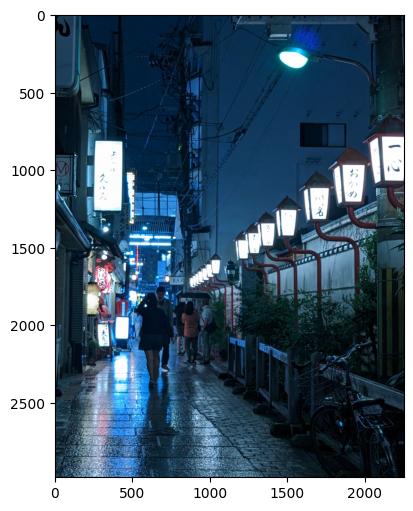

In [3]:
cwd = os.getcwd()
img = Image.open(os.path.join(cwd,'svd_demo.jpg'))
plt.figure(figsize=(9,6))
plt.imshow(img)

I took the above image during a trip to Osaka, Japan in 2023.

I have lots of fond memories from that trip! It was my first time in Japan and I spent a good 18 days there.

Osaka was the last leg and I wanted to capture some cyberpunk-inspired pictures before I left for home.

Now, can I turn these memories into numbers? And how?

In [16]:
# Images come as 3D numpy arrays, 1 array for each colour channel (R, G, B)
np.array(list(img.getdata())).shape

(6705000, 3)

In [22]:
img.size

(2250, 2980)

In [17]:
# We'll get just the 0th band (R) and turn it into a numpy array with the same dimensions as the image
mat = np.array(list(img.getdata(band=0)), float).reshape(img.size[1], img.size[0])
mat

array([[29., 33., 36., ..., 14., 13., 13.],
       [31., 34., 37., ..., 10., 10., 10.],
       [31., 33., 38., ...,  5.,  6.,  6.],
       ...,
       [22., 25., 21., ...,  2.,  0.,  0.],
       [26., 28., 23., ...,  1.,  0.,  0.],
       [37., 39., 33., ...,  0.,  0.,  0.]])

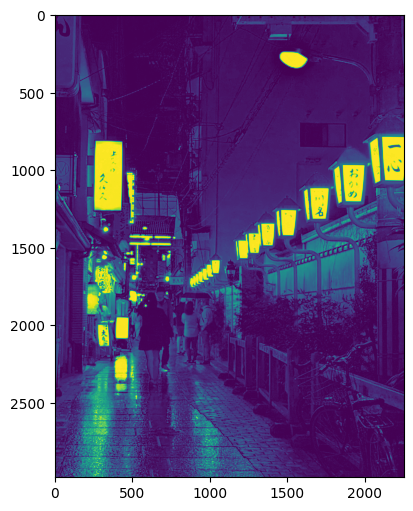

In [18]:
# Visualise the one-channel matrix as an image
plt.figure(figsize=(9,6))
plt.imshow(mat)

# Basic Properties of Matrices
To understand how compression is done on a matrix, first we have to understand a matrix.

First, here are some basic properties of matrices.

1. Matrices can be factorised into 3 component matrices by Singular Value Decomposition (SVD): $ M = U * \Sigma * V^T $
2. Every matrix of real numbers has a Singular Value Decomposition.

In [5]:
U, sigma, VT = np.linalg.svd(mat)

# Intuition: Compressing an Image with Truncated SVD
Now, how do we use $U$, $\Sigma$, and $VT$?

If we multiplied them back together, we would get the exact same image back again, 100%, pixel for pixel, because mathematically, $ M = U * \Sigma * V^T $.

In compressing an image, we know that we lose some resolution.

How is it that we lose resolution but still retain the essential information (shapes and colours) of the image?

Similar to principal component analysis (PCA), we select a certain number ($K$) of rows and columns from each decomposed factor of the matrix.

This will approximate the original matrix using the truncated SVD --> $ M_{compressed} = U_k * \Sigma_k * V^T_k $

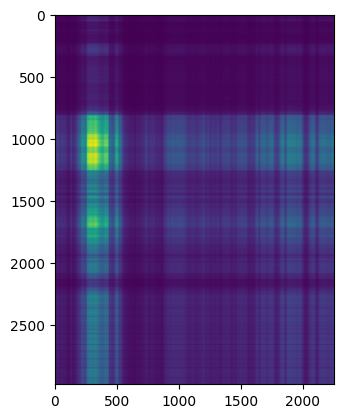

In [19]:
# Let's set K=1 and see what we get out of it
k = 1
uncompress = np.matrix(U[:,:k]) @ np.diag(sigma[:k]) @ np.matrix(VT[:k,:])
plt.imshow(uncompress)

In [ ]:
# How many Singular Values does sigma contain?
len(sigma)

2250

# What's Sigma? Why is it not a matrix? Why did you apply np.diag() to it?


## Sigma
Imagine two arrows orthogonal to each other. These two arrows represent $U$ (left singular vectors) and $V^T$ (right singular vectors).

$\Sigma$ tells you how strong the relationship is between $U$ and $V^T$.

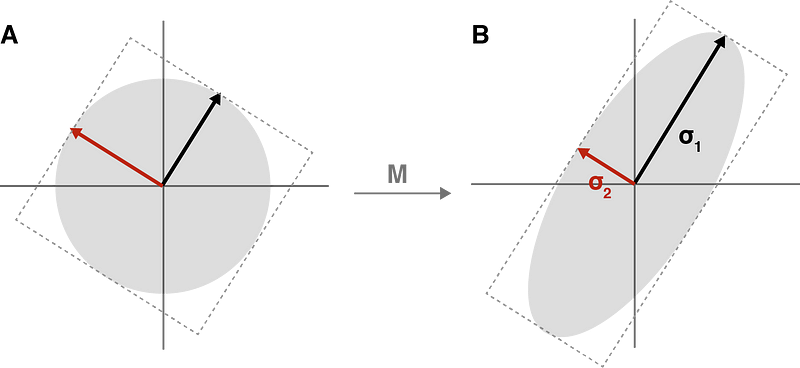

Credit: Gregory Gundersen (https://gregorygundersen.com/blog/2018/12/10/svd/)

You can see a full worked example here: https://medium.com/intuition/singular-value-decomposition-svd-working-example-c2b6135673b5


## Why apply np.diag?

np.diag() is necessary because Sigma is meant to be a diagonal matrix, e.g.:

$ \begin{matrix}
8 & 0 & 0 \\
0 & 4 & 0 \\
0 & 0 & 3 
\end{matrix}  $

Since $M_{compressed} = U_k * \Sigma_k * V^T_k$...

and M is a matrix with dimensions (2980, 2250)...

$\underset{{(2980,k)}}{U_k} * \underset{{(k,k)}}{\Sigma_k} * \underset{{(k,2250)}}{V^T_k} = \underset{{(2980,2250)}}{M_{compressed}}$

Therefore, you must apply np.diag() on Sigma to make it (k,k) dimensions.

## Why is Sigma not a matrix?
As output by Numpy, Sigma is a 1D vector. Why? 

Say the image from my below-average phone camera is 2980 x 2250 matrix. A diagonal Sigma matrix has to be (2250, 2250) in shape with a lot of 0 values. 

This sparse matrix has 5,062,500 values (0.6 to 1 MB) and is very expensive and wasteful to hold in memory or storage for no additional information gained.

It may not be a big deal for an image from my phone, but imagine using images from an ultra-high-res camera which gives you 100,000 x 100,000 pixel images.

Your Sigma has to be (100,000 x 100,000) in shape, again with a lot of 0 values: 10,000,000,000 (10 billion bits, 1.16GB++).

You'll run out of memory and space really fast if you keep a lot of sparse matrices!

## Compression
The first value of Sigma is always the largest. The same goes for $U$ and $V^T$.

By selecting the first K of each and multiplying them together, we can reconstruct the images in varying levels of detail.

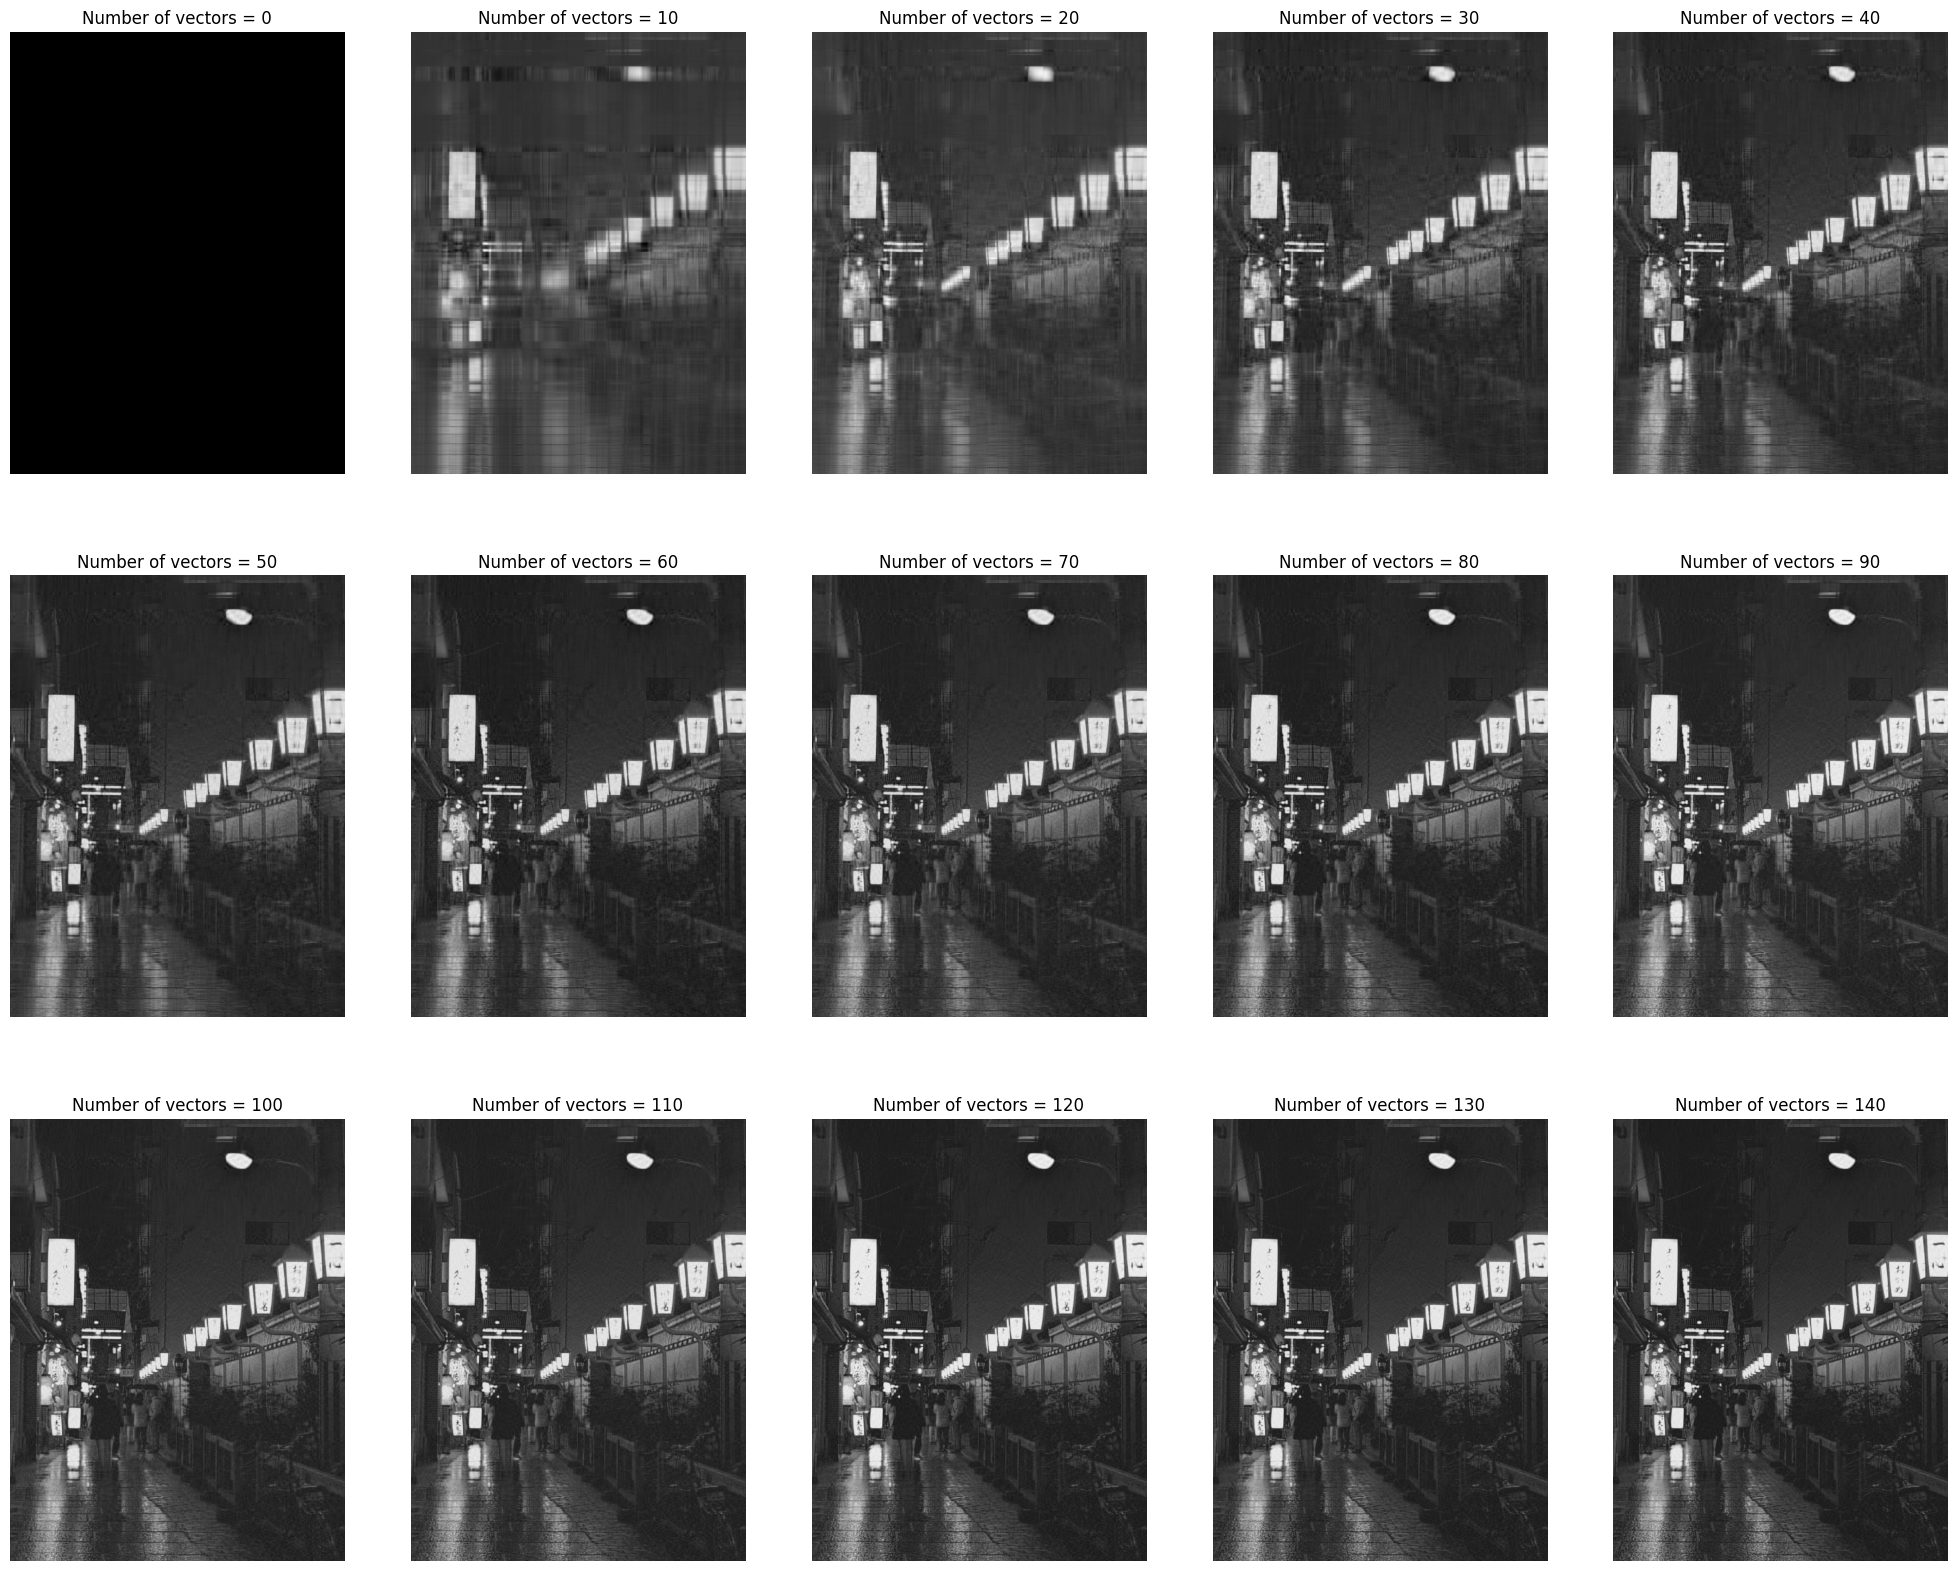

In [69]:
limit = 5
max_vectors = 150
step = 10
fig, ax = plt.subplots(int(max_vectors/step/limit), limit, figsize=(25, 20))

curr_fig=0
for k in range(0, max_vectors, step):
    uncompress = np.matrix(U[:,:k]) @ np.diag(sigma[:k]) @ np.matrix(VT[:k,:])
    title = f"Number of vectors = {k}"
    fignum = int(curr_fig/limit)
    subplot_num = curr_fig%limit
    ax[fignum][subplot_num].imshow(uncompress, cmap='gray',)
    ax[fignum][subplot_num].set_title(title)
    ax[fignum,subplot_num].axis('off')
    curr_fig += 1
plt.show()
    

# Compression successful

We have managed to compress the image successfully using only 140 of the original 2250 vectors.

What's the current image's percentage of the original image size?

In [71]:
# Check compressed image vs. original image size
original_size = np.product(mat.shape)

chosen_k = 140
compressed_size = chosen_k/len(sigma) * mat.shape[0] + chosen_k + chosen_k/len(sigma) * mat.shape[1]
compressed_size/original_size * 100

0.006941420167370951

We're using an incredibly low 0.007% of the original image's data!

Granted, the 140-vector image is still grainy... but it's clear enough that it's the same image I took in Osaka.

This is not how we would use it in real life. The point of the exercise so far was to just demonstrate how much storage space compression can save.

Now, I'm going to try and do the same for a coloured image!

In [10]:
def compress_image(U, S, VT, k):
    return (U[:,:k] @ np.diag(S[:k])) @ VT[:k]

In [72]:
# Read the image in as a 3-dimensional array (3 dimensions corresponding to the R, G, B colour channels)
A = mImage.imread('svd_demo.jpg')
A

array([[[29, 57, 78],
        [33, 61, 82],
        [36, 64, 85],
        ...,
        [14, 30, 45],
        [13, 29, 44],
        [13, 29, 44]],

       [[31, 59, 80],
        [34, 62, 83],
        [37, 65, 86],
        ...,
        [10, 26, 41],
        [10, 26, 41],
        [10, 26, 41]],

       [[31, 62, 83],
        [33, 64, 85],
        [38, 66, 88],
        ...,
        [ 5, 23, 37],
        [ 6, 22, 35],
        [ 6, 22, 35]],

       ...,

       [[22, 53, 73],
        [25, 56, 76],
        [21, 52, 72],
        ...,
        [ 2,  4,  3],
        [ 0,  2,  1],
        [ 0,  2,  1]],

       [[26, 57, 77],
        [28, 59, 79],
        [23, 54, 74],
        ...,
        [ 1,  3,  2],
        [ 0,  2,  1],
        [ 0,  2,  1]],

       [[37, 68, 88],
        [39, 70, 90],
        [33, 64, 84],
        ...,
        [ 0,  2,  1],
        [ 0,  2,  1],
        [ 0,  2,  1]]], dtype=uint8)

In [77]:
# Normalise the image matrices so that all values lie within range 0.0 to 1.0
R = A[:,:,0] / 255
G = A[:,:,1] / 255
B = A[:,:,2] / 255

In [78]:
# Get the SVD vectors of the 3 colour channels
R_U, R_S, R_VT = np.linalg.svd(R)
G_U, G_S, G_VT = np.linalg.svd(G)
B_U, B_S, B_VT = np.linalg.svd(B)

In [79]:
def compress_by_rank(relative_rank:float=1.0):
    """
    This function compresses my Osaka image by "relative_rank". 
    Basically, this parameter stands for how many % of the data do you want to use.
    """
    assert 0.0 <= relative_rank <= 1.0, "Relative rank must be a number between 0.0 and 1.0!"
    max_rank = int(relative_rank * min(R.shape[0], R.shape[1]))
    print("max rank = %d" % max_rank)
    R_comp = compress_image(R_U, R_S, R_VT, max_rank)
    G_comp = compress_image(G_U, G_S, G_VT, max_rank)
    B_comp = compress_image(B_U, B_S, B_VT, max_rank)
    compressed_float = np.dstack((R_comp, G_comp, B_comp))
    compressed = (np.minimum(compressed_float, 1.0) * 255).astype(np.uint8)
    return compressed

max rank = 22


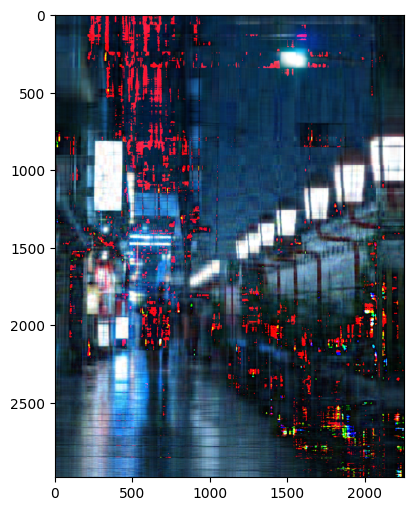

In [80]:
# Let's test 1% of the data
compressed = compress_by_rank(0.01)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

max rank = 112


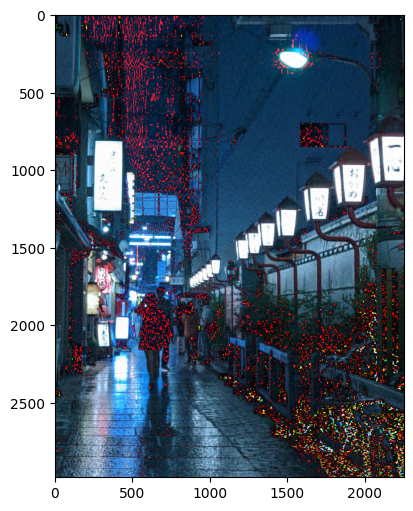

In [81]:
compressed = compress_by_rank(0.05)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

max rank = 225


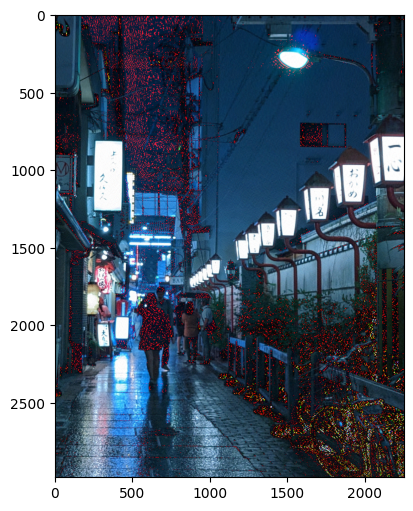

In [82]:
compressed = compress_by_rank(0.10)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

Lots of red and yellow spots around. The image is still very noisy. Let's try 20% of the data.

max rank = 450


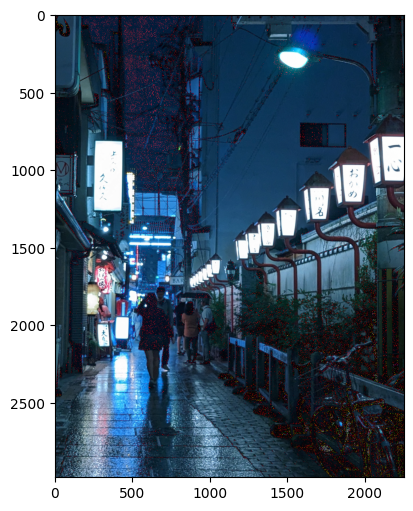

In [83]:
compressed = compress_by_rank(0.20)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

There are still noticeable spots. Let's try 40%.

max rank = 900


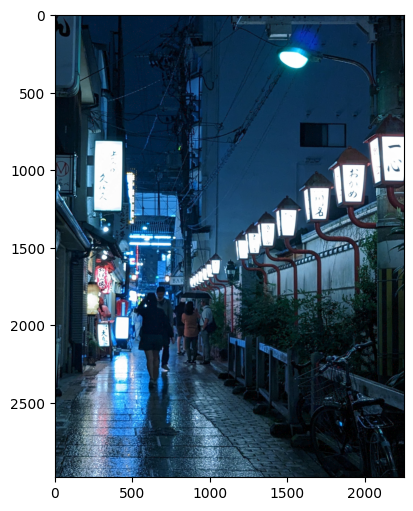

In [88]:
compressed = compress_by_rank(0.40)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

# Finding the best K or best relative rank

It seems that we needed more vectors (900, or 40% of all the data) to get a nice coloured image with no red or green spots.

This is a big difference from greyscale, where just 100 could produce an acceptable image. 

This goes to show that I have more to learn, and that the same rules won't always apply to every transformation.

Also, there seems to have been no weird blue spots -- this is probably due to the image being very dominated by blue and also blue's similarity to black. Maybe the spots are there but it's not noticeable.

## Objective vs. Heuristic Compression

We've managed to find some sweet spots (900 for colour images) by trial and error.

Is there a mathematical, objective way to find the exact rank that minimises the error and maximises the compression?

Yes!

In [89]:
def find_best_k(target_err:float, S:np.ndarray):
    """
    Finds best K from a given Sigma array
    """
    assert 0.0 <= target_err <= 1.0
    squared_err = S**2                  # Sigma is already from largest to smallest... [8, 4, 0]... square it --> [64, 16, 0]
    sorted_err = squared_err[::-1]      # Sort Sigma so that the smallest error will be first and the largest will be last... [0, 16, 64]
    ranks = np.cumsum(sorted_err)[::-1] # Sum all the errors cumulative from smallest to largest... [0, 16, 80]... then reverse them... [80, 16, 0] --> get a list of descending squared error values
    sq_rel_err = ranks/ranks[0]         # Divide all the squared errors by the largest squared error. This lets us find the point at which the error drops sufficiently to meet the target error.
    rel_error = np.sqrt(sq_rel_err)     # Square root all the errors so they can be compared to target error
    return np.min(np.where(rel_error < target_err)) # Get the smallest value of K that meets the targeted error

In [90]:
def compress_by_best_rank(target_err=0.10):
    """
    This function finds the best K for each colour channel.
    """
    best_R_k = find_best_k(target_err, R_S)
    best_G_k = find_best_k(target_err, G_S)
    best_B_k = find_best_k(target_err, B_S)
    print(f'Best K --- R:{best_R_k} | G:{best_G_k} | B:{best_B_k}')
    
    R_comp = compress_image(R_U, R_S, R_VT, best_R_k)
    G_comp = compress_image(G_U, G_S, G_VT, best_G_k)
    B_comp = compress_image(B_U, B_S, B_VT, best_B_k)
    compressed_float = np.dstack((R_comp, G_comp, B_comp))
    compressed = (np.minimum(compressed_float, 1.0) * 255).astype(np.uint8)
    return compressed

Best K --- R:282 | G:239 | B:197


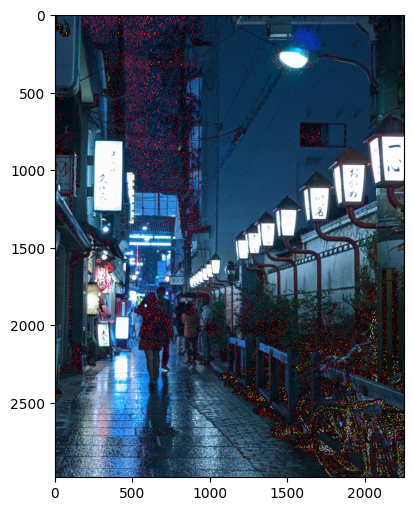

In [99]:
# Let's try allowing 5% error
compressed = compress_by_best_rank(0.05)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

Best K --- R:542 | G:474 | B:417


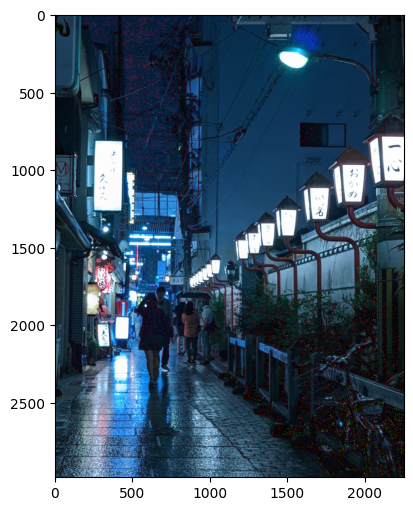

In [101]:
# Hmm. Still lots of red and green spots. 
# Let's target 2% relative error
compressed = compress_by_best_rank(0.02)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

Best K --- R:801 | G:711 | B:647


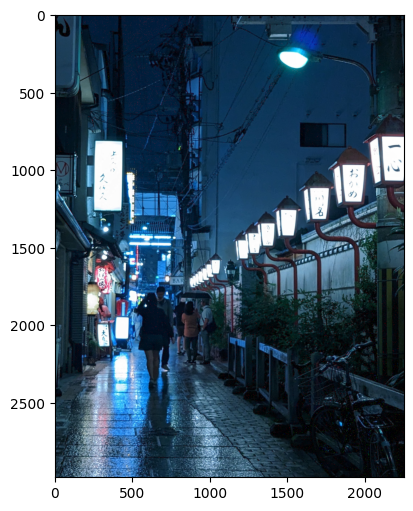

In [103]:
# There are still obvious red and green spots!
# Let's finally target 1% relative error
compressed = compress_by_best_rank(0.01)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

# Conclusion
1. Compression saves a ton of space vs. the original data (99% is possible)
2. It's also possible to compress a colour image in the same way, but you need to do the same process for all 3 colour channels.
3. There is an objective, mathematical way to find the best number of vectors for minimising error to your desired level while maximising the compression effect.
4. It's much easier to compress a greyscale image than a coloured image! The optimal K may differ for each colour channel, and low mathematical error does not mean an acceptable image to the human eye.

# CSE6040 Course Review
I greatly enjoyed CSE6040 at Georgia Tech. 

It gave me a better appreciation of the power of Numpy, the weakness of for loops (especially nested for loops), and the need for alternative storage formats for sparse matrices [e.g. Compressed Sparse Row Format (CSR), Coordinate Format (COO)]

The content was rigorous and required a lot of thinking to resolve challenges intentionally set to prevent you from using "hacky" methods to resolve them.

Some practise problems even had us implementing classic data science algorithms such as Continuous Bag of Words, K Means Clustering, and Neural Network forward passes from scratch using just Numpy.

To me, though, the kicker was being able to put the skills into practise by compressing my own pictures using the skills I just learnt.

Even with my 4 years of experience in data science and programming, I learnt a lot from this module. I'm looking forward to everything else that Georgia Tech has to offer!

# References:

1. https://zerobone.net/blog/cs/svd-image-compression/
2. https://www.frankcleary.com/svdimage/
3. https://medium.com/intuition/singular-value-decomposition-svd-working-example-c2b6135673b5
4. https://gregorygundersen.com/blog/2018/12/10/svd/
